In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
preproc_filepath = ('/users/konstantinosvosinas/Desktop/PREP2025/data/vals_preproc.csv')
denoised_filepath = ('/users/konstantinosvosinas/Desktop/PREP2025/data/vals_denoised.csv')

In [2]:
from scipy.io import loadmat

# Load the .mat file
vals_preproc_mat = loadmat('/users/konstantinosvosinas/Desktop/PREP2025/vals_preproc.mat')
# Display the keys of the loaded .mat file
print(vals_preproc_mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'vals'])


In [40]:
vals_preproc_mat['vals'][0][0][1][2][0].shape

(300, 232)

In [18]:
# Print headers
print("Headers:", )

# Print values for the first row
first_row_values = df_preproc.iloc[0].values
for value in first_row_values:

SyntaxError: incomplete input (132012737.py, line 6)

In [ ]:
headers = df_preproc.columns.to_list()
for i in range(1, len(headers)):
    print(headers[i])


preproc_1
preproc_2
preproc_3
preproc_4
preproc_5
preproc_6
preproc_7
preproc_8
preproc_9
preproc_10
preproc_11
preproc_12
preproc_13
preproc_14
preproc_15
preproc_16
preproc_17
preproc_18
preproc_19
preproc_20
preproc_21
preproc_22
preproc_23
preproc_24
preproc_25
preproc_26
preproc_27
preproc_28
preproc_29
preproc_30
preproc_31
preproc_32
preproc_33
preproc_34
preproc_35
preproc_36
preproc_37
preproc_38
preproc_39
preproc_40
preproc_41
preproc_42
preproc_43
preproc_44
preproc_45
preproc_46
preproc_47
preproc_48
preproc_49
preproc_50
preproc_51
preproc_52
preproc_53
preproc_54
preproc_55
preproc_56
preproc_57
preproc_58
preproc_59
preproc_60
preproc_61
preproc_62
preproc_63
preproc_64
preproc_65
preproc_66
preproc_67
preproc_68
preproc_69
preproc_70
preproc_71
preproc_72
preproc_73
preproc_74
preproc_75
preproc_76
preproc_77
preproc_78
preproc_79
preproc_80
preproc_81
preproc_82
preproc_83
preproc_84
preproc_85
preproc_86
preproc_87
preproc_88
preproc_89
preproc_90
preproc_91
preproc_

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f5981f8f4c0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

,files,preproc_1,preproc_2,preproc_3,preproc_4,preproc_5,preproc_6,preproc_7,preproc_8,preproc_9,...,preproc_173991,preproc_173992,preproc_173993,preproc_173994,preproc_173995,preproc_173996,preproc_173997,preproc_173998,preproc_173999,preproc_174000
0,sub-53888_acq-p402rest0_run-1_desc-preproc_bol...,877,875,872,872,873,871,874,874,874,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub-53888_acq-p402rest1_run-2_desc-preproc_bol...,875,867,872,869,871,878,882,884,879,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub-53888_acq-p402rest2_run-3_desc-preproc_bol...,862,856,855,864,859,859,860,860,858,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sub-53888_acq-p402rest3_run-4_desc-preproc_bol...,838,841,844,840,835,834,837,837,841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-53888_acq-p403rest0_run-5_desc-preproc_bol...,912,912,911,910,917,920,915,919,915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,sub-57214_acq-n0143rest1_run-2_desc-preproc_bo...,2602,2594,2598,2611,2596,2617,2627,2612,2613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,sub-57214_acq-n0143rest2_run-3_desc-preproc_bo...,2573,2577,2560,2558,2544,2514,2536,2539,2528,...,2506.0,2531.0,2475.0,2505.0,2530.0,2552.0,2542.0,2522.0,2487.0,2502.0
132,sub-57214_acq-n0143rest3_run-4_desc-preproc_bo...,2573,2560,2548,2549,2533,2526,2526,2541,2532,...,2530.0,2541.0,2542.0,2551.0,2539.0,2567.0,2608.0,2606.0,2574.0,2562.0
133,sub-57214_acq-n0143rest5_run-5_desc-preproc_bo...,2439,2445,2424,2397,2434,2410,2444,2423,2414,...,2432.0,2435.0,2477.0,2478.0,2458.0,2429.0,2445.0,2428.0,2426.0,2426.0


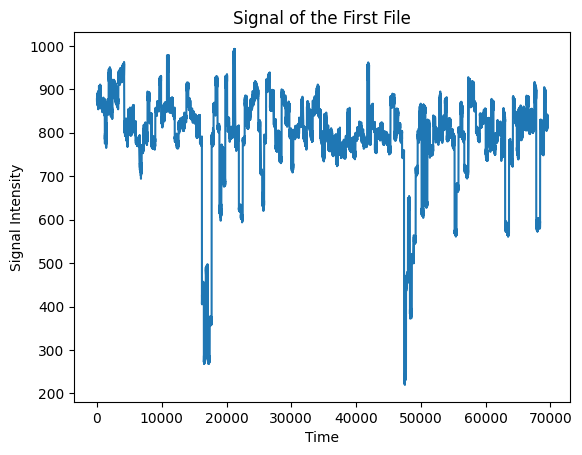

In [17]:
signal = df_preproc.iloc[0].scan

# Plot the signal
plt.plot(signal)
plt.title('Signal of the First File')
plt.xlabel('Time')
plt.ylabel('Signal Intensity')
plt.show()

In [ ]:
# Filter rows that include "run-1" in the filename
run_1_rows = df_preproc[df_preproc['filename'].str.contains('run-1')]

# Create a new dataframe with run-1 rows
df_run_1 = pd.DataFrame(run_1_rows)
print(df_run_1)

In [34]:
run_1_rows = df_preproc[df_preproc['filename'].str.contains('run-1')].reset_index(drop=True)

# Create a new dataframe with run-1 rows
df_run_1 = pd.DataFrame(run_1_rows)
df_run_1

,filename,scan
0,sub-53888_acq-p402rest0_run-1_desc-preproc_bol...,"[877.0, 875.0, 872.0, 872.0, 873.0, 871.0, 874..."
1,sub-55162_acq-n0033rest0_run-1_desc-preproc_bo...,"[2684.0, 2664.0, 2693.0, 2659.0, 2683.0, 2653...."
2,sub-55729_acq-p417rest0_run-1_desc-preproc_bol...,"[824.0, 827.0, 829.0, 830.0, 827.0, 826.0, 829..."
3,sub-55746_acq-p430rest0_run-1_desc-preproc_bol...,"[802.0, 810.0, 810.0, 804.0, 806.0, 806.0, 810..."
4,sub-55772_acq-p410rest0_run-1_desc-preproc_bol...,"[781.0, 783.0, 783.0, 783.0, 778.0, 778.0, 782..."
5,sub-55809_acq-n0043rest0_run-1_desc-preproc_bo...,"[2381.0, 2406.0, 2384.0, 2403.0, 2384.0, 2398...."
6,sub-55965_acq-p435rest0_run-1_desc-preproc_bol...,"[949.0, 945.0, 948.0, 951.0, 951.0, 953.0, 944..."
7,sub-55988_acq-p397rest0_run-1_desc-preproc_bol...,"[878.0, 881.0, 881.0, 883.0, 890.0, 896.0, 900..."
8,sub-55992_acq-p381rest0_run-1_desc-preproc_bol...,"[912.0, 906.0, 913.0, 906.0, 907.0, 915.0, 914..."
9,sub-56017_acq-n0047rest0_run-1_desc-preproc_bo...,"[2696.0, 2685.0, 2693.0, 2670.0, 2676.0, 2682...."


In [36]:
df_run_1.iloc[0].scan.shape

(174000,)

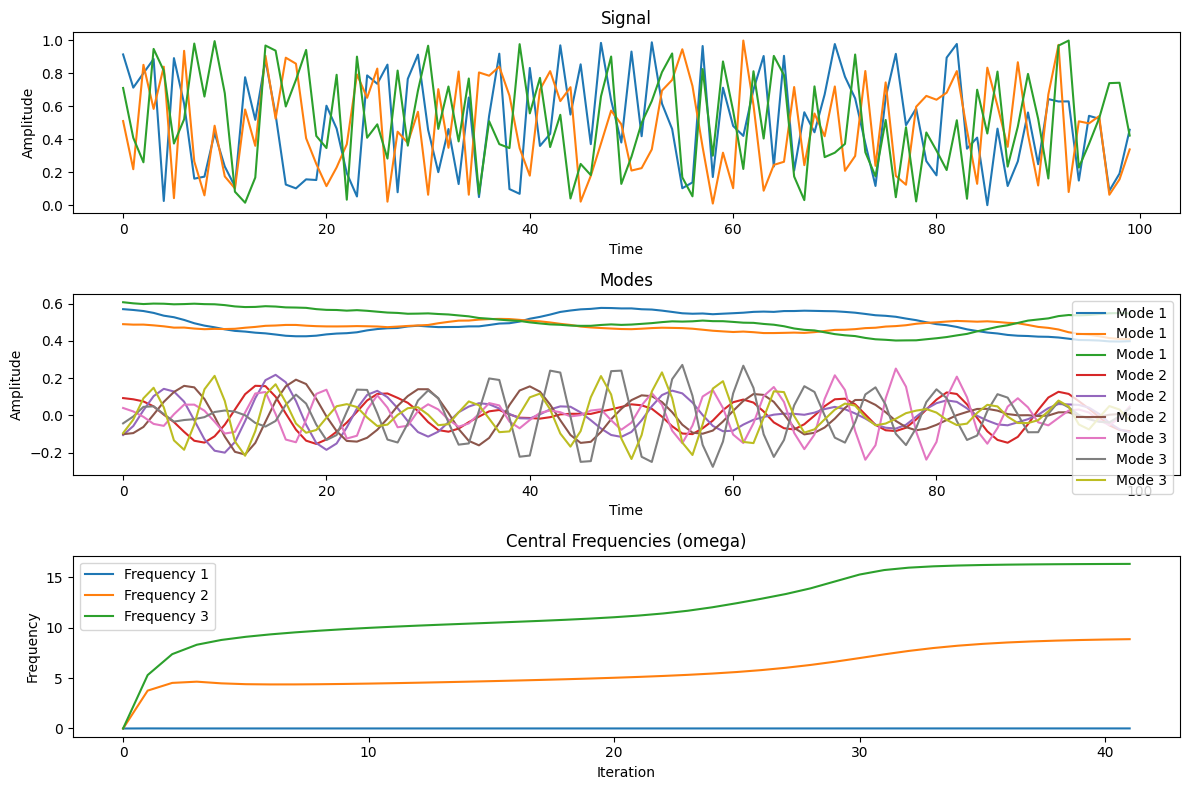

In [30]:
# Plot the signal
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(signal.T)
plt.title('Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot the modes
plt.subplot(3, 1, 2)
for i in range(modes.shape[0]):
    plt.plot(modes[i].T, label=f'Mode {i+1}')
plt.title('Modes')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

# Plot the central frequencies
plt.subplot(3, 1, 3)
for i in range(omega.shape[1]):
    plt.plot(omega[:, i], label=f'Frequency {i+1}')
plt.title('Central Frequencies (omega)')
plt.xlabel('Iteration')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()